# ⚛️ H₃⁺ ADAPT-VQE

Runs the packaged ADAPT-VQE implementation and reports:
- final energy
- operator growth + stopping metric
- inner-loop convergence traces
- selected operator list + final parameters
- final ADAPT circuit diagram

Compares against standard VQE (UCCSD).

## 🔧 Imports & Configuration

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from vqe.adapt import run_adapt_vqe
from vqe.core import run_vqe
from vqe.hamiltonian import build_hamiltonian
from vqe.engine import make_device

from common.plotting import build_filename, save_plot


molecule = "H3+"
seed = 0

mapping = "jordan_wigner"
optimizer = "Adam"
steps = 75
stepsize = 0.2

# ADAPT controls
pool = "uccsd"  # uccsd | uccs | uccd
max_ops = 20
grad_tol = 1e-3

print("Molecule:", molecule)
print("Mapping:", mapping)
print("Optimizer:", optimizer)
print("Inner steps:", steps, "| Inner stepsize:", stepsize)
print("ADAPT pool:", pool, "| max_ops:", max_ops, "| grad_tol:", grad_tol)

Molecule: H3+
Mapping: jordan_wigner
Optimizer: Adam
Inner steps: 75 | Inner stepsize: 0.2
ADAPT pool: uccsd | max_ops: 20 | grad_tol: 0.001


## 🚀 Run ADAPT-VQE (Package API)

/home/codespace/.local/lib/python3.12/site-packages/autograd/tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")



💾 Saved ADAPT-VQE run record: results/vqe/H3plus_adapt_vqe_uccsd_adam_noiseless_s0_b29d1a70ccc9_adapt.json



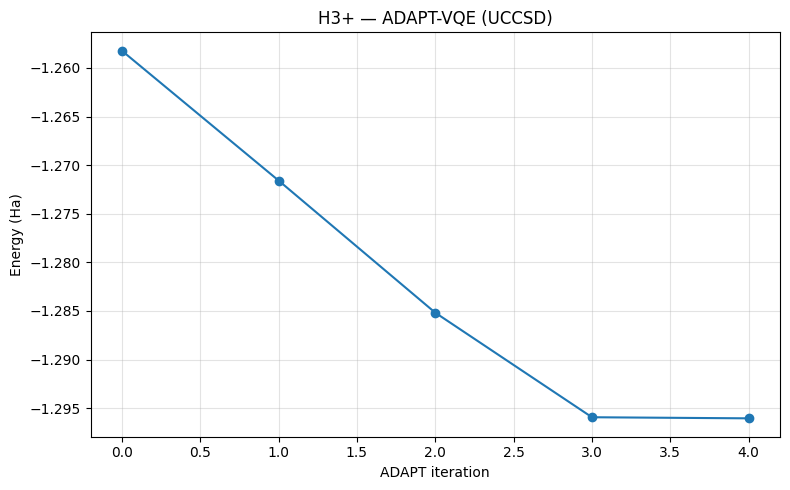

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/adapt_conv_ADAPT_UCCSD_Adam_jordan_wigner_s0.png


In [9]:
res_adapt = run_adapt_vqe(
    molecule=molecule,
    pool=pool,
    max_ops=int(max_ops),
    grad_tol=float(grad_tol),
    optimizer_name=optimizer,
    inner_steps=int(steps),
    inner_stepsize=float(stepsize),
    seed=int(seed),
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    mapping=mapping,
    plot=True,
    force=False,
)

## ✅ Summary

In [10]:
E_adapt = float(res_adapt.get("energy", np.nan))
ops = res_adapt.get("selected_operators", [])
theta = np.array(res_adapt.get("final_params", []), dtype=float)

print("\nADAPT-VQE — Summary (noiseless)\n")
print(f"Final energy (Ha): {E_adapt:+.10f}")

if isinstance(ops, (list, tuple)):
    print(f"Selected operators: {len(ops)}")
else:
    print("Selected operators: (not returned)")
    ops = []

if len(ops) > 0:
    print("\nOperator list (first 10):")
    for i, op in enumerate(ops[:10]):
        print(f"  {i:02d}: {op}")


ADAPT-VQE — Summary (noiseless)

Final energy (Ha): -1.2960399948
Selected operators: 4

Operator list (first 10):
  00: {'kind': 'double', 'wires': [0, 1, 4, 5]}
  01: {'kind': 'double', 'wires': [1, 2, 3, 4]}
  02: {'kind': 'single', 'wires': [1, 5]}
  03: {'kind': 'single', 'wires': [0, 4]}


## 📉 Stopping metric: max |∂E/∂θ| per append step

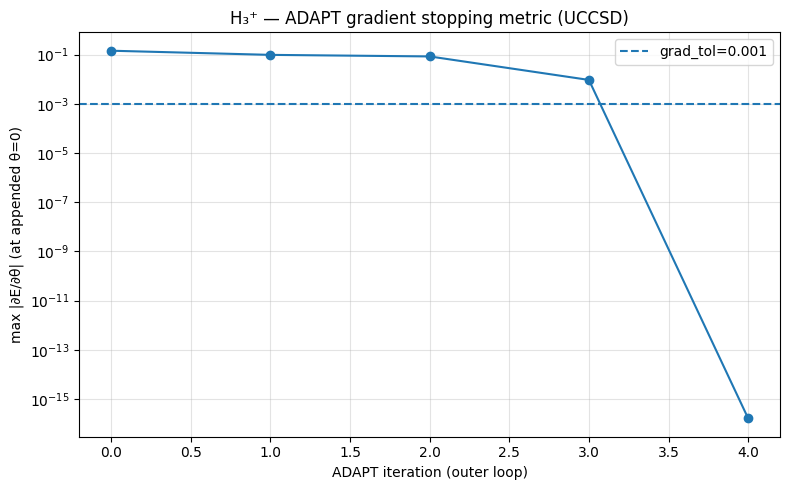

In [11]:
gmax = np.array(res_adapt.get("max_gradients", []), dtype=float)
xg = np.arange(len(gmax), dtype=int)

plt.figure(figsize=(8, 5))
plt.semilogy(xg, gmax, marker="o")
plt.axhline(
    float(grad_tol),
    linestyle="--",
    linewidth=1.5,
    label=f"grad_tol={grad_tol:g}",
)
plt.xlabel("ADAPT iteration (outer loop)")
plt.ylabel("max |∂E/∂θ| (at appended θ=0)")
plt.grid(True, which="both", alpha=0.35)
plt.legend()
plt.title(f"H₃⁺ — ADAPT gradient stopping metric ({pool.upper()})")
plt.tight_layout()
plt.show()

## 📈 Inner-loop convergence traces

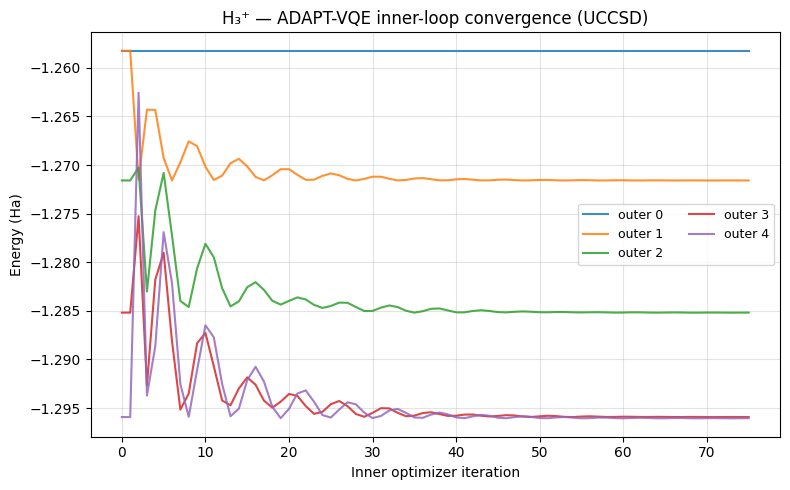

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/adapt_inner_conv_ADAPT_UCCSD_Adam_jordan_wigner_s0.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/adapt_inner_conv_ADAPT_UCCSD_Adam_jordan_wigner_s0.png'

In [12]:
inner = res_adapt.get("inner_energies", [])

plt.figure(figsize=(8, 5))
for k, traj in enumerate(inner):
    plt.plot(traj, label=f"outer {k}", alpha=0.85)

plt.xlabel("Inner optimizer iteration")
plt.ylabel("Energy (Ha)")
plt.grid(True, alpha=0.35)
plt.title(f"H₃⁺ — ADAPT-VQE inner-loop convergence ({pool.upper()})")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()

fname = build_filename(
    topic="adapt_inner_conv",
    ansatz=f"ADAPT_{pool.upper()}",
    optimizer=optimizer,
    mapping=mapping,
    seed=int(seed),
    multi_seed=False,
)

save_plot(fname, kind="vqe", molecule=molecule, show=True)


## 🧪 Baseline comparison: VQE(UCCSD)

In [13]:
res_vqe = run_vqe(
    molecule=molecule,
    seed=int(seed),
    steps=int(steps),
    stepsize=float(stepsize),
    ansatz_name="UCCSD",
    optimizer_name=optimizer,
    noisy=False,
    mapping=mapping,
    plot=False,
    force=False,
)
E_vqe = float(res_vqe.get("energy", np.nan))

print("\nBaseline comparison (noiseless)\n")
print(f"ADAPT-VQE final energy:  {E_adapt:+.10f} Ha")
print(f"VQE(UCCSD) final energy: {E_vqe:+.10f} Ha")
if np.isfinite(E_adapt) and np.isfinite(E_vqe):
    print(f"Δ final energy:          {E_adapt - E_vqe:+.10e} Ha")


Baseline comparison (noiseless)

ADAPT-VQE final energy:  -1.2960399948 Ha
VQE(UCCSD) final energy: -1.2960315950 Ha
Δ final energy:          -8.3998283371e-06 Ha


## 🧩 Draw final ADAPT circuit

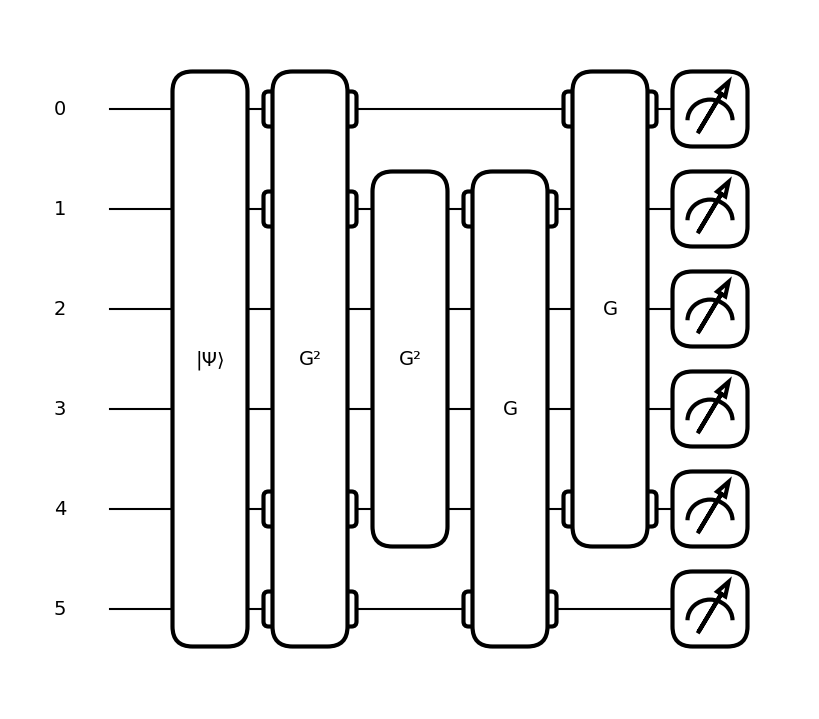

In [14]:
if len(ops) == 0:
    print("No operators available; skipping circuit drawing.")
else:
    H, n_wires, hf_state, *_ = build_hamiltonian(molecule, mapping=mapping, unit="angstrom")
    dev_draw = make_device(int(n_wires), noisy=False)

    def _apply_adapt(theta_vec):
        qml.BasisState(np.array(hf_state, dtype=int), wires=range(int(n_wires)))
        for t, op in zip(theta_vec, ops):
            if op["kind"] == "single":
                qml.SingleExcitation(t, wires=op["wires"])
            elif op["kind"] == "double":
                qml.DoubleExcitation(t, wires=op["wires"])
            else:
                raise ValueError(f"Unknown kind: {op['kind']}")

    @qml.qnode(dev_draw)
    def circuit(theta_vec):
        _apply_adapt(theta_vec)
        return qml.expval(H)

    # Matplotlib drawing
    fig, ax = qml.draw_mpl(circuit)(theta)
    plt.show()